In [18]:
import pandas as pd
import json
import pickle
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os,sys,inspect, pickle
import numpy as np

pd.set_option('display.max_colwidth', 500)

CSV_PATH = '../tpch_graphs_for_table_wo_2_17_20'
BENCHMARK = 'tpch'
SCALE_FACTOR = 10
# all except 2,17,20 because they dominate costs by orders of magnitude
QUERIES = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21,22]
X_AXIS_TITLE = 'Index Storage Consumption (GB)'
LABEL_FONT_SIZE = 12
TITLE_FONT_SIZE = 13
MARKER_SIZE = 7
LINE_WIDTH = 1
GRAPH_SIZE = (5,3.333)
algorithms = sorted(['epic', 'drop_heuristic', 'microsoft', 'microsoft_naive_2', 'dexter', 'ibm', 'cophy'])

In [19]:
class Style():
    def __init__(self, label, color, marker, hatch):
        self.label = label
        self.color = color
        self.marker = marker
        self.hatch = hatch
        self.index_history = None
styles = {
    'epic': Style('Extend', '#4e79a7', 'd', '/'),
    'drop_heuristic': Style('Drop', '#f28e2b', 'P', 'o'),
    'microsoft': Style('AutoAdmin', '#e15759', '.', '.'),
    'microsoft_naive_2': Style('Naive 2', '#9c755f', '.', ''),
    'dexter': Style('Dexter', '#bab0ac', 'X', 'x'),
    'ibm': Style('DB2Advis', '#59a14f', '*', '*'),
    'no_index': Style('No Index', '#76b7b2', '-', 'O'),
    'cophy': Style('CoPhy', '#b07aa1', 'p', '\\')
}
# edc948, , 9c755f, bab0ac, ff9da7

# styles = {
#     'epic': Style('EPIC', '#fc8d62'),
#     'drop_heuristic': Style('Drop', '#66c2a5'),
#     'microsoft': Style('MS', '#8da0cb'),
#     'dexter': Style('Dexter', '#e78ac3'),
#     'ibm': Style('IBM', '#a5d854'),
#     'no_index': Style('No Index', '#ffd92f'),
#     'cophy': Style('CoPhy', '#b3b3b3'),
# }
# set2-8-qual-7 = 229,196,148

In [20]:
def b_to_gb(b):
    return b / 1000 / 1000 / 1000

def mb_to_gb(mb):
    return mb / 1000

def s_to_m(s):
    return s / 60

def get_costs(df):
    costs = []
    
    for _, row in df.iterrows():
        row_cost = 0
        for column in df.columns:
            if column[0] == 'q':
                row_cost += float(json.loads(row[column])['Cost'])
        costs.append(row_cost)
    
    return costs

In [21]:
def draw_cost_graph(cophy_costs=None, cophy_memory_consumption=None):
    no_index_df = pd.read_csv(f"{CSV_PATH}/results_no_index_{BENCHMARK}_{len(QUERIES)}_queries.csv", sep=';')
    no_index_cost = get_costs(no_index_df)[0]
    fig, ax = plt.subplots()
    for algorithm in algorithms:
        if algorithm == 'microsoft_naive_2':
            continue
        
        style = styles[algorithm]

        if algorithm == 'cophy':
            if cophy_costs is not None and cophy_memory_consumption is not None:
                relative_costs = list(map(lambda x: x / no_index_cost * 100, cophy_costs))
                memory_consumptions_gb = list(map(lambda x: mb_to_gb(x), cophy_memory_consumption))
                memory_consumptions_gb = list(filter(lambda x: x < XLIM, memory_consumptions_gb))
                relative_costs = relative_costs[:len(memory_consumptions_gb)]
                ax.step(memory_consumptions_gb, relative_costs, where='post', color=style.color, linewidth=LINE_WIDTH)
                ax.plot(memory_consumptions_gb, relative_costs, f'{style.marker}', color=style.color, label=style.label, markersize=MARKER_SIZE)
            continue

        csv_path= f"{CSV_PATH}/results_{algorithm}_{BENCHMARK}_{len(QUERIES)}_queries.csv"
        df = pd.read_csv(csv_path, sep=';')
        if algorithm == 'dexter':
            df = df.iloc[::-1]
        df['memory consumption'] = df['memory consumption'].apply(b_to_gb)
        df = df.query(f'`memory consumption` < {XLIM}')

        costs = get_costs(df)
        relative_costs = list(map(lambda x: x / no_index_cost * 100, costs))

        ax.step(df['memory consumption'], relative_costs, where='post', color=style.color, linewidth=LINE_WIDTH)
        ax.plot(df['memory consumption'], relative_costs, f'{style.marker}', color=style.color, label=style.label, markersize=MARKER_SIZE)

    fig.legend()
    plt.xlabel(X_AXIS_TITLE, fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Relative workload cost\n (% to no index)', fontsize=LABEL_FONT_SIZE)
    sf_string = f' (SF {SCALE_FACTOR})' if SCALE_FACTOR is not None else ''
#     plt.title(f'{BENCHMARK.upper()}{sf_string}: Performance vs Memory Budget', fontsize=TITLE_FONT_SIZE)

    fig.set_size_inches(GRAPH_SIZE)
    fig.tight_layout()
    ax.set_xlim([-0.1, XLIM])
    fig.savefig(f"{CSV_PATH}/{BENCHMARK.lower()}_cost_estimation.pdf", bbox_inches='tight')

def draw_runtime_graph(minutes=False, cophy_runtimes=None, cophy_memory_consumption=None):
    fig, ax = plt.subplots()
    for algorithm in algorithms:
        if algorithm == 'cophy' or algorithm == 'microsoft_naive_2':
            continue
        style = styles[algorithm]
        csv_path= f"{CSV_PATH}/results_{algorithm}_{BENCHMARK}_{len(QUERIES)}_queries.csv"
        df = pd.read_csv(csv_path, sep=';')
        df['memory consumption'] = df['memory consumption'].apply(b_to_gb)
        df = df.query(f'`memory consumption` < {XLIM}')
        runtime = df['algorithm runtime'].apply(s_to_m) if minutes else df['algorithm runtime']
        ax.step(df['memory consumption'], runtime, where='post', color=style.color, linewidth=LINE_WIDTH)
        ax.plot(df['memory consumption'], runtime, f'{style.marker}', color=style.color, label=style.label, markersize=MARKER_SIZE)
    fig.legend()
    plt.xlabel(X_AXIS_TITLE, fontsize=LABEL_FONT_SIZE)
    ylabel_unit = 'minutes' if minutes else 'seconds'
    plt.ylabel(f'Algorithm runtime ({ylabel_unit})', fontsize=LABEL_FONT_SIZE)
    sf_string = f' (SF {SCALE_FACTOR})' if SCALE_FACTOR is not None else ''
#     plt.title(f'{BENCHMARK.upper()}{sf_string}: Algorithm Runtime vs Memory Budget', fontsize=TITLE_FONT_SIZE)

    fig.set_size_inches(GRAPH_SIZE)
    fig.tight_layout()
    ax.set_xlim([-0.1, XLIM])
    fig.savefig(f"{CSV_PATH}/{BENCHMARK.lower()}_runtime.pdf", bbox_inches='tight')
    
def draw_what_if_graph(million=False):
    def determine_max_created_indexes_in_epic(df_epic):
        indexed_column_steps = df['indexed columns'].values
        numbers_of_indexes = []
        for indexed_column_step in indexed_column_steps:
            number_of_indexes = indexed_column_step.count('I(C')
            numbers_of_indexes.append(number_of_indexes)

        return numbers_of_indexes

    print('Average cache rates:')
    width = 0.22
    pos = None
    labels = None
    fig, ax = plt.subplots()
    idx = 0
    for algorithm in algorithms:
        style = styles[algorithm]
        if algorithm == 'cophy':
            continue
        if algorithm not in['microsoft', 'drop_heuristic', 'microsoft_naive_2']:
            continue
        csv_path= f"{CSV_PATH}/results_{algorithm}_{BENCHMARK}_{len(QUERIES)}_queries.csv"
        df = pd.read_csv(csv_path, sep=';')
        df = df.head(XLIM)
        if idx == 0:
            labels = df.index + 1
            pos = np.arange(len(labels))
        requests = df['cost requests'] / 1000000 if million else df['cost requests']
        hits = df['cache hits'] / 1000000 if million else df['cache hits']
        ax.bar([p + width * idx for p in pos], requests - hits, width, bottom=hits, label=style.label, color=style.color, hatch=style.hatch)
        ax.bar([p + width * idx for p in pos], hits, width, color=style.color, alpha=0.5, hatch=style.hatch) # label=f"{style.label} (cached)",

        avg_cache_rate = (hits / requests).mean()
        print(f'  {style.label}: {avg_cache_rate}')
        
        idx += 1


    algorithm = 'epic'
    style = styles[algorithm]
    csv_path= f"{CSV_PATH}/results_{algorithm}_{BENCHMARK}_{len(QUERIES)}_queries.csv"
    df = pd.read_csv(csv_path, sep=';')
    df['number of indexes'] = determine_max_created_indexes_in_epic(df)
    df = df.sort_values(by=['number of indexes'])
    df = df.groupby('number of indexes').first()
    cache_hits = list(df['cache hits'].values)
    cost_requests = list(df['cost requests'].values)
    for i in range(len(labels) - len(cache_hits)):
        cache_hits.append(0)
        cost_requests.append(0)
    requests = list(map(lambda x: x / 1000000, cost_requests)) if million else cost_requests
    hits = list(map(lambda x: x / 1000000, cache_hits)) if million else cache_hits
    requests_hits_difference = list(map(lambda x, y: x - y, requests, hits))
    ax.bar([p + width * idx for p in pos], requests_hits_difference, width, bottom=hits, label=style.label, color=style.color, hatch=style.hatch)
    ax.bar([p + width * idx for p in pos], hits, width, color=style.color, alpha=0.5, hatch=style.hatch) #label=f"{style.label} (cached)"
    idx += 1
    
    rates = []
    for hit, request in zip(hits, requests):
        if request <= 0:
            continue
        rates.append(hit / request)
    avg_cache_rate = np.mean(rates)
    print(f'  {style.label}: {avg_cache_rate}')

    ax.set_xticks([p + ((idx - 1) / 2) * width for p in pos])
    ax.set_xticklabels(labels)
    ax.legend()
    ylabel_string = '(millions)' if million else ''
    plt.ylabel(f'Cost requests {ylabel_string}', fontsize=LABEL_FONT_SIZE)
    plt.xlabel('Number of indexes', fontsize=LABEL_FONT_SIZE)
    fig.tight_layout()
    fig.set_size_inches(GRAPH_SIZE)
    ax.set_xlim([-0.2, len(labels) - 0.2])
    plt.show()

    fig.savefig(f"{CSV_PATH}/{BENCHMARK.lower()}_what_if_graph.pdf", bbox_inches='tight')
    

## TPCH - Cost

In [22]:
CSV_PATH = '../tpch_graphs_for_table_wo_2_17_20'
BENCHMARK = 'tpch'
SCALE_FACTOR = 10
# all except 2,17,20 because they dominate costs by orders of magnitude
QUERIES = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21,22]
XLIM = 10

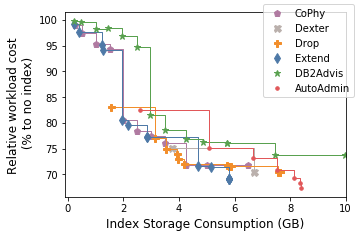

In [23]:
cophy_memory_consumptions_mb = [250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4250, 5000, 6500]
cophy_costs = [34396397.79, 33854446.79, 33133046.48, 32783525.42, 27986156.77, 27258434.02, 26896370.87, 26442926.89, 24993712.59, 24976459.99, 24954672.03]
draw_cost_graph(cophy_costs, cophy_memory_consumptions_mb)

## TPCH - Runtime

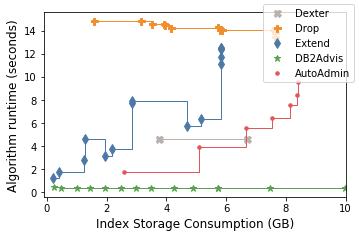

In [24]:
draw_runtime_graph()

## TPCH - What If Graph

Average cache rates:
  Drop: 0.9552367368982783
  AutoAdmin: 0.5591256910461982
  Naive 2: 0.4732331127967718
  Extend: 0.7985811187635923


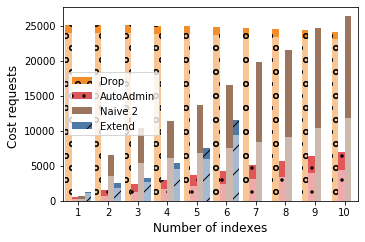

In [25]:
draw_what_if_graph()


## TPCH - Query Chart

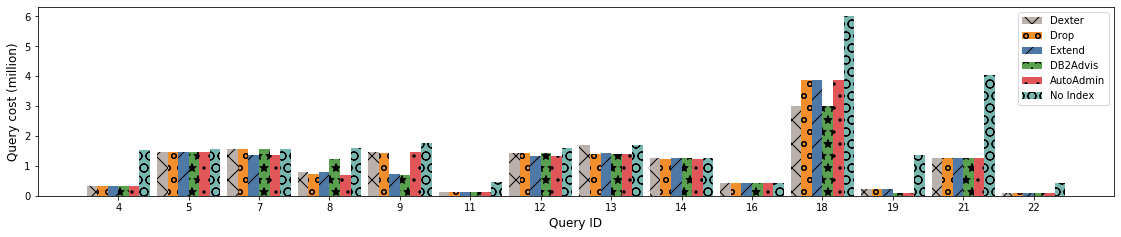

In [26]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir)

from selection.index import Index
from selection.workload import Workload
from selection.cost_evaluation import CostEvaluation
from selection.dbms.postgres_dbms import PostgresDatabaseConnector
from selection.what_if_index_creation import WhatIfIndexCreation

workload = pickle.load(open(f'{CSV_PATH}/workload.pickle', 'rb'))
# Filter uninteresting ones
workload.queries = [query for query in workload.queries if query.nr not in [1, 6, 10]]
styles['microsoft'].index_history = pickle.load(open(f'{CSV_PATH}/microsoft_index_combination_history.pickle', 'rb'))
styles['drop_heuristic'].index_history = pickle.load(open(f'{CSV_PATH}/drop_index_drop_history.pickle', 'rb'))
styles['epic'].index_history = pickle.load(open(f'{CSV_PATH}/epic_index_combination_history.pickle', 'rb'))
styles['ibm'].index_history = pickle.load(open(f'{CSV_PATH}/ibm_index_combination_history.pickle', 'rb'))
styles['dexter'].index_history = pickle.load(open(f'{CSV_PATH}/dexter_index_combination.pickle', 'rb'))
styles['no_index'].index_history = []

pdc = PostgresDatabaseConnector('indexselection_tpch___10')
what_if = WhatIfIndexCreation(pdc)

def workload_to_str(workload):
    return str(workload.queries)

cache = {}

def what_if_cost(workload, index_combination):
    cache_key = (workload_to_str(workload), frozenset(index_combination))
    if cache_key not in cache:
        database_connector = PostgresDatabaseConnector('indexselection_tpch___10')
        cost_evaluation = CostEvaluation(database_connector)
        cost = cost_evaluation.calculate_cost(workload, index_combination)
        cache[cache_key]= cost
        database_connector.close()
    else:
        cost = cache[cache_key]
    return cost

def exploit_indexes(recommended_indexes_per_query, indexes):
    for index in indexes:
        what_if.simulate_index(index, store_size=True)

    for query in workload.queries:
        plan = pdc.get_plan(query)
        plan_string = str(plan)
        cost = plan['Total Cost']
#         recommended_indexes_per_query[query.nr] = (cost / no_index_costs[query.nr] * 100, [])
        recommended_indexes_per_query[query.nr] = (cost / 1000000, [])
        for index in indexes:
            if index.hypopg_name in plan_string:
                recommended_indexes_per_query[query.nr][1].append(index)
    what_if.drop_all_simulated_indexes()

def costs_from_dict(d):
    costs = []
    for key in sorted(d.keys()):
        costs.append(d[key][0])
    return costs

no_index_costs = {}
for query in workload.queries:
    no_index_costs[query.nr] = what_if_cost(Workload([query], 'ejal'), [])

width = 0.15
pos = None
labels = None
fig, ax = plt.subplots()
idx = 0
for algorithm in algorithms + ['no_index']:
    style = styles[algorithm]
    if style.index_history is None:
        continue
    recommended_indexes = {}
    exploit_indexes(recommended_indexes, style.index_history)
    costs = costs_from_dict(recommended_indexes)
    if idx == 0:
        labels = list(recommended_indexes.keys())
        # 3 and 15 ausgelassen wegen Langeweile
        del labels[0]
        del labels[9]
        pos = np.arange(len(labels))
    # 3 and 15 ausgelassen wegen Langeweile
    del costs[0]
    del costs[9]
    ax.bar([p + width * idx for p in pos], costs, width, label=style.label, color=style.color, hatch=style.hatch)
    
    idx += 1

ax.set_xticks([p + ((idx - 1) / 2) * width for p in pos])
ax.set_xticklabels(labels)
ax.legend()
# plt.ylabel('Query cost in % of w/o indexes', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Query cost (million)', fontsize=LABEL_FONT_SIZE)
plt.xlabel('Query ID', fontsize=LABEL_FONT_SIZE)
# plt.title('Performance impact of final index combination per algorithm', fontsize=TITLE_FONT_SIZE)
fig.tight_layout()
fig.set_size_inches(17, 3.25)
plt.show()

pdc.close()
fig.savefig(f"{CSV_PATH}/{BENCHMARK.lower()}_query_graph.pdf", bbox_inches='tight')

## TPCDS - Cost

In [27]:
CSV_PATH = '../tpcds_wo_4_6_9_10_11_32_35_41_95'
BENCHMARK = 'tpcds'
SCALE_FACTOR = 10
QUERIES = [1, 2, 3, 5, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99]
XLIM = 12

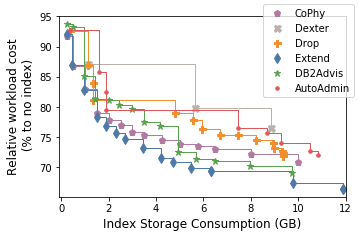

In [28]:
cophy_memory_consumptions_mb = [250,500,1000,1500,2000,2500,3000,3500,4250,5000,5750,6500,8000,10000,12500,15000]
cophy_costs = [93552156.13, 88577114.46, 84585359.84, 80591549.13, 79399996.85, 78585000.31, 77435060.04, 76792132.12, 75967528.65, 75365979.03, 74943369.35, 74457654.57, 73613863.17, 72363984.63, 71776031.09, 71534655.96]
draw_cost_graph(cophy_costs, cophy_memory_consumptions_mb)

## TPCDS - Runtime

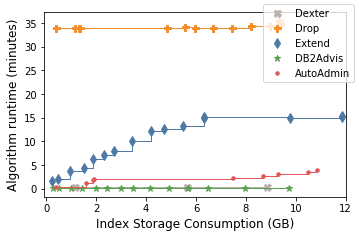

In [29]:
draw_runtime_graph(minutes=True)

## TPCDS - What If Graph

Average cache rates:
  Drop: 0.9930077558664173
  AutoAdmin: 0.6724238946097137
  Naive 2: 0.5955803691694753
  Extend: 0.9372585912136393


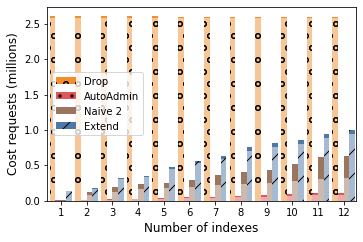

In [30]:
draw_what_if_graph(million=True)

## JOB - Cost

In [31]:
CSV_PATH = '../job'
BENCHMARK = 'JOB'
SCALE_FACTOR = None
QUERIES = range(0, 113)
XLIM = 12

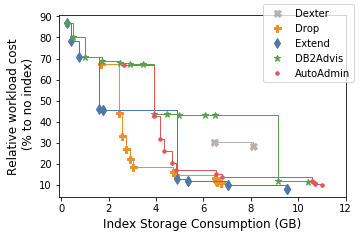

In [32]:
draw_cost_graph()

## JOB - Runtime

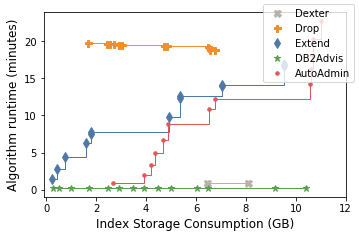

In [33]:
draw_runtime_graph(minutes=True)

## JOB - What If Graph

Average cache rates:
  Drop: 0.8800921748183114
  AutoAdmin: 0.466242169829028
  Naive 2: 0.5110223453155758
  Extend: 0.759021028639644


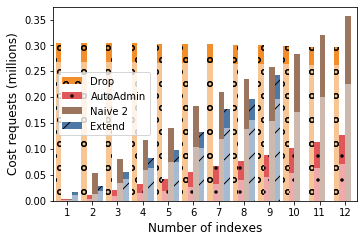

In [34]:
draw_what_if_graph(million=True)